#Training and Evaluating Xception Model

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras import utils
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing import image as preprocessing_image
from tensorflow.keras import applications
from tensorflow.keras import callbacks

#Load Pre-Trained Xception Model

In [3]:
lrn_rate=0.001
epoch = 30
batch_siz= 128
IMAGE_size=224

In [4]:
BASE_DIR = "E:\ourProject\Inception and Xception\Dataset"

# preprossecing and ahumantation
train_datagen = preprocessing_image.ImageDataGenerator(rescale=1/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

# Get Images form the dir
train_generator = train_datagen.flow_from_directory(os.path.join(BASE_DIR, "train"), target_size=(IMAGE_size,IMAGE_size), batch_size=batch_siz, class_mode='categorical')
validation_generator = train_datagen.flow_from_directory(os.path.join(BASE_DIR, "val"), target_size=(IMAGE_size,IMAGE_size), batch_size=batch_siz, class_mode='categorical')


Found 16979 images belonging to 32 classes.
Found 3636 images belonging to 32 classes.


In [7]:
# Number of classes in the output layer
class_number = len(validation_generator.class_indices.keys())
class_number


32

In [8]:
# load pre-trained Xception model and exclude top dense layer
base_model = applications.Xception(include_top=False,
                                   weights='imagenet',
                                   input_shape=(IMAGE_size,IMAGE_size,3))


In [9]:
print("Model input shape: {}\n".format(base_model.input_shape))
print("Model output shape: {}\n".format(base_model.output_shape))
print("Model number of layers: {}\n".format(len(base_model.layers)))

Model input shape: (None, 224, 224, 3)

Model output shape: (None, 7, 7, 2048)

Model number of layers: 132



#Fine-tune Xception Model

In [10]:
base_model.trainable = False

In [11]:
def fine_tune_Xception(base_model):

    inputs = Input(shape=(IMAGE_size, IMAGE_size, 3))

    x = base_model(inputs, training=False)

    x = layers.GlobalAveragePooling2D()(x)

    # final Dense layer
    outputs = layers.Dense(class_number, activation='softmax')(x)

    # define model with base_model's input
    model = models.Model(inputs=inputs, outputs=outputs)



    return model

#Compile Model

In [12]:
def compile_model(model):

    # loss
    loss = losses.categorical_crossentropy

    # optimizer
    optimizer = optimizers.Adam(learning_rate=lrn_rate)

    # metrics
    metric = [metrics.categorical_accuracy]

    # compile model with loss, optimizer, and evaluation metrics
    model.compile(optimizer, loss, metric)

    return model

In [13]:
model = fine_tune_Xception(base_model)
model = compile_model(model)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
Total params: 20927048 (79.83 MB)
Trainable params: 65568 (256.12 KB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


#Image Preprocessing And Augmentation

#Train Model on Custome Dataset

In [14]:
print("Model input shape: {}\n".format(model.input_shape))
print("Model output shape: {}\n".format(model.output_shape))
print("Model number of layers: {}\n".format(len(model.layers)))

Model input shape: (None, 224, 224, 3)

Model output shape: (None, 32)

Model number of layers: 4



In [15]:
early_stopping = callbacks.EarlyStopping(
     monitor='val_loss',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

In [16]:
history = model.fit(
    train_generator,
    epochs=epoch,
    callbacks=[early_stopping],
    validation_data = validation_generator
    )

Epoch 1/30


133/133 [==============================] - 1170s 9s/step - loss: 1.3784 - categorical_accuracy: 0.7205 - val_loss: 0.6633 - val_categorical_accuracy: 0.8691
Epoch 2/30
133/133 [==============================] - 1085s 8s/step - loss: 0.5095 - categorical_accuracy: 0.9012 - val_loss: 0.4087 - val_categorical_accuracy: 0.9172
Epoch 3/30
133/133 [==============================] - 1071s 8s/step - loss: 0.3461 - categorical_accuracy: 0.9306 - val_loss: 0.2979 - val_categorical_accuracy: 0.9431
Epoch 4/30
133/133 [==============================] - 1060s 8s/step - loss: 0.2679 - categorical_accuracy: 0.9469 - val_loss: 0.2411 - val_categorical_accuracy: 0.9563
Epoch 5/30
133/133 [==============================] - 1059s 8s/step - loss: 0.2229 - categorical_accuracy: 0.9551 - val_loss: 0.2114 - val_categorical_accuracy: 0.9579
Epoch 6/30
133/133 [==============================] - 1058s 8s/step - loss: 0.1877 - categorical_accuracy: 0.9630 - val_loss: 0.1804 - val_categorical_accurac

#Plot Accuracy And Loss Over Time

In [24]:
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))

    # plot train and val accuracy
    plt.subplot(221)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('SqueezeNet accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    # plot train and val loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('SqueezeNet loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')

    plt.show()

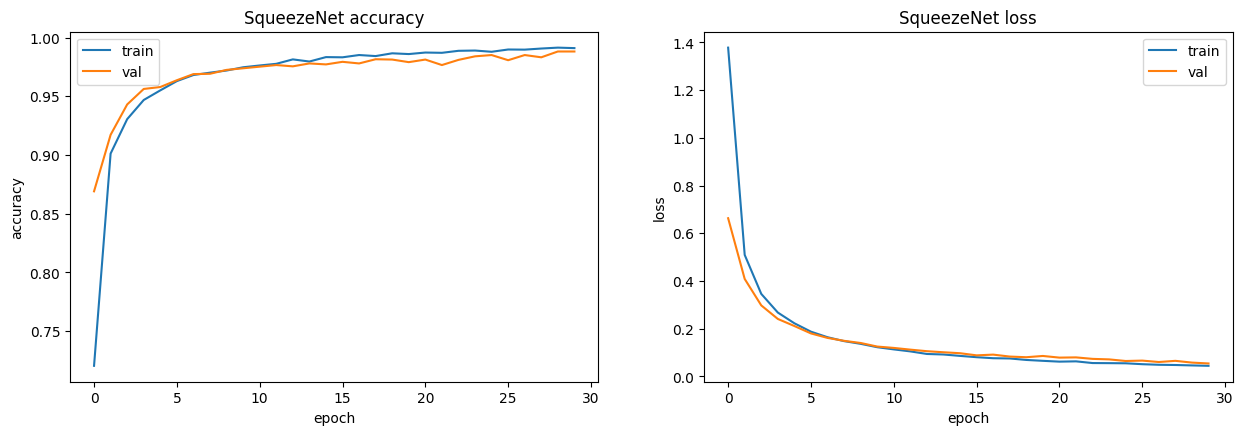

In [25]:
plot_accuracy_and_loss(history)

In [19]:
# save model architecture
model_json = model.to_json()
open('xception_model_ev.json', 'w').write(model_json)

# save model's learned weights
model.save_weights('image_classifier_xception_ev.h5', overwrite=True)

In [21]:
train_generator.labels

array([ 0,  0,  0, ..., 31, 31, 31])

In [28]:
BASE_DIR = "E:\ourProject\Inception and Xception\Dataset"

test_datagen= preprocessing_image.ImageDataGenerator(rescale=1/255)

test_set = test_datagen.flow_from_directory(os.path.join(BASE_DIR, "test"), target_size=(224,224), batch_size=128, class_mode='categorical')


Found 3630 images belonging to 32 classes.


In [30]:
y_test =test_set.labels

In [35]:
y_test = np.array(y_test)

In [38]:
y_test =y_test.reshape((-1, 1))

In [39]:
y_test

array([[ 0],
       [ 0],
       [ 0],
       ...,
       [31],
       [31],
       [31]])

In [41]:
print("Evaluate on test data")
results = model.evaluate(test_set, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
29/29 [==============================] - 227s 8s/step - loss: 0.0509 - categorical_accuracy: 0.9871
test loss, test acc: [0.0509055070579052, 0.987052321434021]


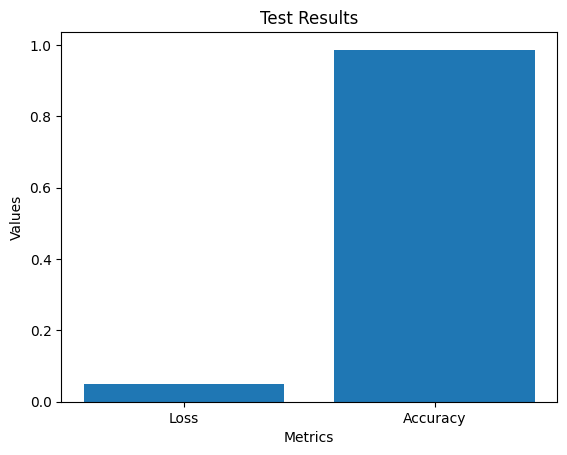

In [48]:
import matplotlib.pyplot as plt

# Assuming you have the evaluation results stored in the 'evaluation' variable
loss = results[0]
accuracy = results[1]

# Create a bar plot to visualize the evaluation results
metrics = ['Loss', 'Accuracy']
values = [loss, accuracy]

plt.bar(metrics, values)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Test Results')
plt.show()